<a href="https://colab.research.google.com/github/LaurenVaught/DogsVsCats/blob/main/Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingest

##Libaries

In [2]:
import os, cv2, random, shutil
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.output import eval_js
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

# from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError
# from yellowbrick.style import set_palette

from sklearn.model_selection import train_test_split
from time import time
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from sklearn.metrics import accuracy_score, f1_score, roc_curve, recall_score, precision_score

import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

##Kaggle API

In [3]:
! pip install -q kaggle

In [4]:
#
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"laurenvaught","key":"5ddc41fdcbb4ca643c93acdb36279f38"}'}

In [5]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                              title                                               size  lastUpdated          downloadCount  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
yasserh/wine-quality-dataset                                     Wine Quality Dataset                                21KB  2022-01-15 19:15:11           7608  
mkoklu42/pistachio-dataset                                       Pistachio Dataset                                    2MB  2022-02-11 21:06:50             63  
prasertk/netflix-subscription-price-in-different-countries       Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09           5849  
majyhain/height-of-male-and-female-by-country-2022               Height of Male and Female by Country 2022            4KB  2022-02-02 00:40

In [6]:
! kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

 98% 532M/544M [00:04<00:00, 176MB/s]
100% 544M/544M [00:04<00:00, 125MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 116MB/s]
 97% 264M/271M [00:01<00:00, 157MB/s]
100% 271M/271M [00:01<00:00, 174MB/s]


##Unzip Files

In [7]:
import zipfile
train = ! unzip 'train.zip'
test= ! unzip 'test.zip'

#EDA

In [11]:
#https://www.kaggle.com/dilipkumar2k6/dogs-vs-cats-with-new-kernel
# Extract the first 3 letters from the image names, to generate one hot encoding labels
def label_pet_image(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return 0
    elif pet == 'dog': return 1

In [12]:
# Process the data (both train and test set)
from tqdm import tqdm
import cv2
from random import shuffle
IMG_SIZE=64
# set sample size
SAMPLE_SIZE=20000
def process_data(DATA_FOLDER, isTrain=True):
    # Read images from extracted directory
    image_list = os.listdir(DATA_FOLDER)
    filtered_image_list = image_list[0:SAMPLE_SIZE if isTrain else len(image_list)]
    data_df = [] # data frame
    for img in tqdm(filtered_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        try:
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            data_df.append([np.array(img),label])
        except Exception as e:
            print("Image with issue name, path, isTrain, label", img, path, isTrain, label)
            print(str(e))            
    shuffle(data_df)
    return data_df

In [13]:
train = process_data('./train')

100%|██████████| 20000/20000 [00:56<00:00, 352.68it/s]


In [14]:
test = process_data('./test', False)

100%|██████████| 12500/12500 [00:33<00:00, 372.13it/s]


In [16]:
# plot to see how it looks
from matplotlib import pyplot as plt
%matplotlib inline
def plot_sample(data, isTrain=True):
    img = data[0]
    plt.figure(figsize=(15,2))
    plt.imshow(img)
    if isTrain:
        plt.xlabel(classes[data[1]])


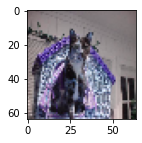

In [17]:
#visualize image
plot_sample(test[4], False)

#ANN Model

In [18]:
# Prepare the train data
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])
test_X = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [19]:
# normalize our data in 0-1
X = X/255
test_X = test_X/255

In [20]:
from sklearn.model_selection import train_test_split
train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size=0.3)

In [21]:
train_y

array([0, 1, 1, ..., 0, 1, 0])

In [23]:
import tensorflow as tf
from tensorflow import keras
# First apply Artificial neural network (ANN)
ann = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Flaten 3d to 1d
    keras.layers.Dense(3000, activation='relu'), # more hidden layer gives better perf
    keras.layers.Dense(1000, activation='relu'), # more hidden layer gives better perf
    keras.layers.Dense(100, activation='relu'), # more hidden layer gives better perf
    keras.layers.Dense(1, activation='sigmoid')    
])
ann.compile(optimizer='SGD', loss= keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
#test epoch at 10... leave 1 for now
ann.fit(train_X, train_y, epochs=10)

Epoch 1/10
438/438 [==============================] - 83s 189ms/step - loss: 0.6752 - accuracy: 0.5784
Epoch 2/10
438/438 [==============================] - 81s 185ms/step - loss: 0.6531 - accuracy: 0.6154
Epoch 3/10
438/438 [==============================] - 76s 174ms/step - loss: 0.6391 - accuracy: 0.6336
Epoch 4/10
438/438 [==============================] - 79s 181ms/step - loss: 0.6277 - accuracy: 0.6463
Epoch 5/10
438/438 [==============================] - 78s 178ms/step - loss: 0.6168 - accuracy: 0.6576
Epoch 6/10
438/438 [==============================] - 78s 178ms/step - loss: 0.6111 - accuracy: 0.6650
Epoch 7/10
438/438 [==============================] - 80s 182ms/step - loss: 0.5977 - accuracy: 0.6789
Epoch 8/10
438/438 [==============================] - 79s 181ms/step - loss: 0.5914 - accuracy: 0.6806
Epoch 9/10
438/438 [==============================] - 79s 181ms/step - loss: 0.5797 - accuracy: 0.6927
Epoch 10/10
438/438 [==============================] - 78s 179ms/step - l

In [24]:
ann.evaluate(validation_X, validation_y)

188/188 [==============================] - 15s 81ms/step - loss: 0.6263 - accuracy: 0.6557


[0.6262895464897156, 0.6556666493415833]

In [25]:
pred_y = ann.predict(test_X)

In [26]:
pred_y

array([[0.1695078 ],
       [0.51127267],
       [0.81316876],
       ...,
       [0.7515782 ],
       [0.551398  ],
       [0.47046414]], dtype=float32)

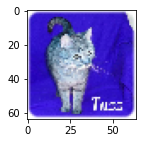

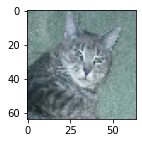

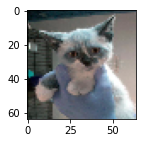

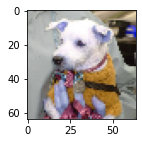

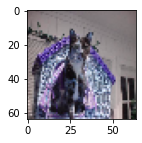

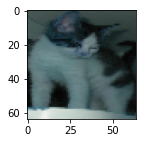

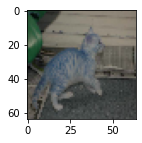

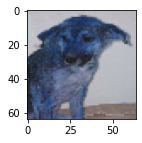

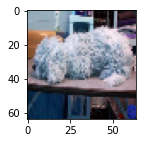

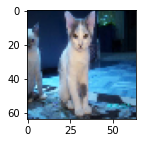

In [27]:
for i in range(0,10):
    plot_sample(test[i], False)

In [28]:
ID = pd.DataFrame()
ID['ImageId'] = test.index
resultsann= pred_y

submitann = pd.concat([ID,pd.DataFrame(resultsann)],axis=1)
submitann.columns = ['ImageId','Label']


# Submitting the output
submitann.to_csv('ann_submission.csv',index=False)

#CNN Model

In [29]:
# Apply CNN
cnn = keras.Sequential([
    # cnn layer
    keras.layers.Conv2D(filters=IMG_SIZE, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)),
    keras.layers.MaxPooling2D(2,2),
    # second layer for cnn
    keras.layers.Conv2D(filters=IMG_SIZE, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # dense layer
    keras.layers.Flatten(), # Flaten 3d to 1d
    keras.layers.Dense(IMG_SIZE, activation='relu'),    # cnn will already reduce layers so need less here
    keras.layers.Dense(1, activation='softmax') # softmax will normalize probability   
])
cnn.compile(optimizer='SGD', loss= keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn.fit(train_X, train_y, epochs=5)

Epoch 1/5
438/438 [==============================] - 116s 263ms/step - loss: 0.6829 - accuracy: 0.4999
Epoch 2/5
438/438 [==============================] - 117s 267ms/step - loss: 0.6624 - accuracy: 0.4999
Epoch 3/5
438/438 [==============================] - 117s 266ms/step - loss: 0.6470 - accuracy: 0.4999
Epoch 4/5
438/438 [==============================] - 118s 269ms/step - loss: 0.6291 - accuracy: 0.4999
Epoch 5/5
438/438 [==============================] - 117s 266ms/step - loss: 0.6144 - accuracy: 0.4999


In [30]:
cnn.evaluate(validation_X, validation_y)

188/188 [==============================] - 13s 71ms/step - loss: 0.5971 - accuracy: 0.5032


[0.5971311330795288, 0.503166675567627]

In [32]:
ID = pd.DataFrame()
ID['ImageId'] = test.index
resultscnn= pred_y

submitcnn = pd.concat([ID,pd.DataFrame(resultscnn)],axis=1)
submitcnn.columns = ['ImageId','Label']


# Submitting the output
submitcnn.to_csv('cnn_submission.csv',index=False)

#Transfer Learning Model

In [33]:
def get_images (directory, type=None):
    if type is None:
        images = [directory + i for i in os.listdir(directory)]
        print(f"There are {len(images)} images")
    else:
        images = [directory + i for i in os.listdir(directory) if type in i]
        print(f"There are {len(images)} {type} images")
    return images

train = '/content/train/'
test = '/content/test/'

train_images = get_images(train)
train_dogs = get_images(train, 'dog')
train_cats = get_images(train, 'cat')

test_images = get_images(test)

There are 25000 images
There are 12500 dog images
There are 12500 cat images
There are 12500 images


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7f53201b3c90>,
 [Text(0, 0, 'Dog'), Text(0, 0, 'Cat')])

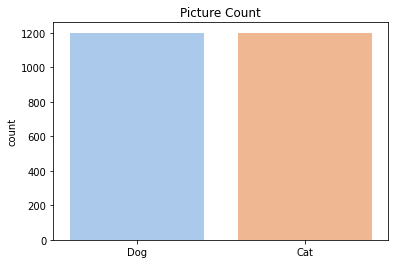

In [35]:
# Randomly select dog and cat images to make subset of training images
train_images = random.sample(train_dogs, 1200) + random.sample(train_cats, 1200)
random.shuffle(train_images)

# Create cat/dog label list
labels = []
for img_name in train_images:
    if 'dog' in img_name:
        labels.append(1)
    else:
        labels.append(0)

# View label distribution
sns.set_palette('pastel')
sns.countplot(labels).set(title='Picture Count')
plt.xticks(ticks=[0,1], labels=['Dog', 'Cat'])

In [37]:
##https://www.kaggle.com/paulamaran/cats-vs-dog-using-transfer-learning
import os
import pandas as pd
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [38]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-02-28 22:47:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  39.8MB/s    in 2.1s    

2022-02-28 22:47:43 (39.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [40]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_2[0][0]']               
 alization)                                                                                       
                                                                                       

In [41]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [42]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_2[0][0]']               
 alization)                                                                                       
                                                                                              

In [43]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [44]:
filenames = os.listdir('/content/train/')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,dog.10496.jpg,1
1,cat.1180.jpg,0
2,dog.4375.jpg,1
3,dog.2119.jpg,1
4,dog.11736.jpg,1


In [45]:
df["category"].value_counts()

1    12500
0    12500
Name: category, dtype: int64

In [46]:
source_path = '/content/' 

source_path_train = os.path.join(source_path, 'train')
source_path_test = os.path.join(source_path, 'test')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_train))} images for training.")
print(f"There are {len(os.listdir(source_path_test))} images for testing.")

There are 25000 images for training.
There are 12500 images for testing.


In [47]:
# Define root directory
root_dir = '/kaggle/working/cats-v-dogs' #this is new folder

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

      
os.makedirs(root_dir + '/training')
os.makedirs(root_dir + '/testing')
os.makedirs(root_dir + '/training/cats')
os.makedirs(root_dir + '/training/dogs')
os.makedirs(root_dir + '/testing/cats')
os.makedirs(root_dir + '/testing/dogs')

In [48]:
#cheking
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/kaggle/working/cats-v-dogs/training
/kaggle/working/cats-v-dogs/testing
/kaggle/working/cats-v-dogs/training/dogs
/kaggle/working/cats-v-dogs/training/cats
/kaggle/working/cats-v-dogs/testing/dogs
/kaggle/working/cats-v-dogs/testing/cats


In [49]:
# split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    files = []
    for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
            files.append(filename)
      else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
    pass


In [50]:
# Define paths
TRAINING_SOURCE_DIR = "/content/train/"
TRAINING_CATS_DIR = "/kaggle/working/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/kaggle/working/cats-v-dogs/testing/cats/"

TEST_SOURCE_DIR = "/content/test/"
TRAINING_DOGS_DIR = "/kaggle/working/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/kaggle/working/cats-v-dogs/testing/dogs/"

TRAINING_DIR = "/kaggle/working/cats-v-dogs/training/"
TESTING_DIR = "/kaggle/working/cats-v-dogs/testing/"

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
    for file in os.scandir(TESTING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
    for file in os.scandir(TESTING_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images for cats/dogs AS SHOWN BEFORE
split_size = .5

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(TRAINING_SOURCE_DIR, TRAINING_CATS_DIR, TRAINING_DOGS_DIR, split_size)
split_data(TEST_SOURCE_DIR, TESTING_CATS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")



There are 12500 images of cats for training
There are 12500 images of dogs for training
There are 6250 images of cats for testing
There are 6250 images of dogs for testing


In [51]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

#train_datagen = ImageDataGenerator(rescale=1/255)
                            
# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

 # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
validation_datagen =  ImageDataGenerator(rescale=1/255)
    
  # Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=100,
                                                               class_mode='binary',
                                                              #classes=('dogs','cats'),
                                                                target_size=(150, 150))


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.


In [52]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9000):
              print("\nReached 90.00% accuracy so cancelling training!")
        self.model.stop_training = True
        
#Instantiate class
callbacks = myCallback()

In [53]:
# Train the model
history = model.fit(
      train_generator,
      epochs=1)
     #validation_data=validation_generator)
     # callbacks=callbacks)
     # verbose=2)
     #test at 1 epoch

250/250 [==============================] - 1073s 4s/step - loss: 0.7326 - accuracy: 0.5027


In [ ]:
model.save_weights('model_catsvsdogs.h5')
model.save('model_catsvsdogs.h5')

In [ ]:
validation_generator.reset()
pred= model.predict_generator(validation_generator, verbose=1)

predicted_class_indices=[1 if x >= 0.5 else 0 for x in pred]

labels=(validation_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]

#print(predicted_class_indices)
#print(labels)
#print(predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


125/125 [==============================] - 492s 4s/step


In [ ]:
counter = range(1, len(predictions) + 1)
solution = pd.DataFrame({"id": counter, "label":predicted_class_indices})
solution.to_csv("dogsVScats.csv", index = False)

#Conclusion

After pre-processing, categorizing, and hyperparameter tuning of the images with an ANN, CNN, and additional Transfer learning model, an accuracy of 70.37%, 50.32%, and 50.36% were achieved respectively. Further modeling and testing are necessary to improve accuracy and limit loss.

##Not used but useful

#Misc


In [9]:
pre_trained_model.summary()

NameError: ignored

In [8]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

NameError: ignored

In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

NameError: ignored

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import os
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import random

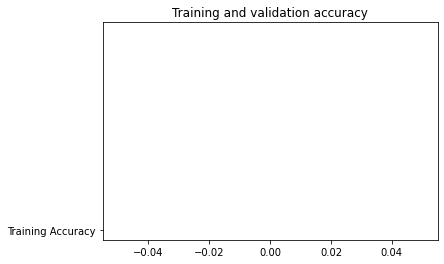

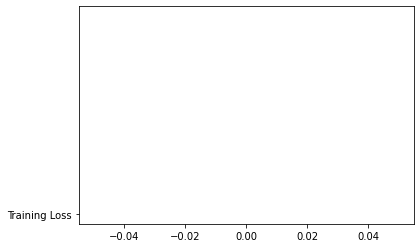

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
accuracy=history.history['accuracy']
#val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs=range(len(accuracy)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, accuracy, 'r', "Training Accuracy")
#plt.plot(epochs, val_accuracy, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
#plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(300, 280)


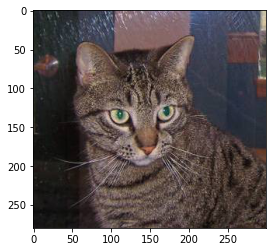

In [ ]:
# load the image
img = load_img('cat.1.jpg')
#img = load_img('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train/cat.1.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
# img.show()
plt.imshow(img)
